# Solving the Schrödinger Equation with Neural Networks

## Introduction

Quantum mechanics fundamentally describes the behavior of particles at microscopic scales. The main equation for the quantum processes is the **Schrödinger equation**. It is a linear partial differential equation. Fundamentally, it is a time dependent equation since Hamiltonian operator involves a time derivative, and also potential energy functions may be time dependent. However, for time independent potentials we can reduce the equation into a simpler form called **Time Independent Schrödinger Equation**. This notebook demonstrates how to approximate solutions to the time-independent Schrödinger equation for a quantum particle in a one-dimensional harmonic oscillator potential using neural networks.

## The Schrödinger Equation

The time-independent Schrödinger equation is given by:

$$
-\frac{\hbar^2}{2m} \frac{d^2\psi(x)}{dx^2} + V(x)\psi(x) = E\psi(x).
$$

For simplicity, we set units such that $ \hbar = 1 $ and $m = 1$, reducing the equation to:

$$
-\frac{1}{2} \frac{d^2\psi(x)}{dx^2} + V(x)\psi(x) = E\psi(x).
$$
## The Harmonic Oscillator

We focus on the harmonic oscillator potential:

$$
V(x) = \frac{1}{2}x^2
$$

where we assumed unit angular frequency, i.e. $w=1$.This potential is fundamental in quantum mechanics. In fact, it is fundamental for almost all physical processes since it describes systems near stable equilibrium points.

## Neural Network Approach

### Wavefunction Representation

We represent the wavefunction $ \psi(x)  $ using a neural network. The network takes position $ x  $ as input and outputs $ \psi(x)  $. The wavefunction roughly can be interpreted as probability density function for the position of the particle. For example, a particle cannot be located in $x$ values where $\psi(x)=0$.

### Loss Function

The goal is to minimize the energy of the system, which is expectation value of the Hamiltonian:

$$
\text{Loss} = \frac{\langle \psi | H | \psi \rangle}{\langle \psi | \psi \rangle}
$$

### Orthogonality Constraints

To find excited states, we enforce orthogonality to all previously found wavefunctions:

$$
\int_{-\infty}^{\infty} \psi_n(x) \psi_m(x) \, dx = \delta_{nm}
$$

### Training Process

1. **Ground State:** Train the neural network to find the ground state by minimizing the energy.

2. **Excited States:** Train additional networks for excited states, adding penalties for overlaps with lower states to enforce orthogonality. In general, the next lowest energy state which is orthogonal to ground state must be first excited state in quantum systems. We can extend this property to find nth eigenstate by minimizing energy while enforcing orthogonality to all previous n-1 eigenstates.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define the potential function for the harmonic oscillator
# We assume m=w=1
def V(x):
    return 0.5 * x**2  # Harmonic oscillator potential


# Function to compute the kinetic energy term (-0.5 d²ψ/dx²) assuming hbar=1
def kinetic_energy(psi, x):
    # First derivative
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi),
                                  create_graph=True, retain_graph=True)[0]
    # Second derivative
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx),
                                    create_graph=True, retain_graph=True)[0]
    return -0.5 * d2psi_dx2

In [ ]:
# Define the neural network to represent the wavefunction ψ(x)
# Neutwork takes position of a particle and returns wavefunction value at that position.
class WaveFunctionNN(nn.Module):

    def __init__(self, layer_sizes=[1, 60, 60, 1]):
        super(WaveFunctionNN, self).__init__()

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Adding activation function for all layers except the last lasyer
                layers.append(nn.Tanh())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [ ]:
# Define a callback function to early stop training if there is no improvement
# greater than min_delta threshold within number of epochs equal to patience value.
class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = None
        self.best_model_state = None
        self.epochs_without_improvement = 0
        self.stop_training = False

    def __call__(self, epoch, energy, model):
        # Initialize the best energy if it's the first epoch
        if self.best_energy is None:
            self.best_energy = energy
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
        else:
            # Check if the energy has improved by more than min_delta
            if energy < self.best_energy - self.min_delta:
                self.best_energy = energy
                self.best_model_state = copy.deepcopy(model.state_dict())
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        # If there is no improvement for the specified patience, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Stopping training after {epoch+1} epochs due to no improvement in energy.")
            self.stop_training = True


In [ ]:
# Function to train a wavefunction neural network
def train_wavefunction(model, optimizer, x_train, previous_wavefunctions=[], epochs=1000, print_interval=250,
                       overlap_penalty=1e2,callback=None,save_wavefunction_history=True):
    energy_history = []
    wave_function_history=[]

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass: compute ψ(x) using the neural network
        psi = model(x_train)

        # Compute kinetic and potential energy terms
        T = kinetic_energy(psi, x_train)
        V_psi = V(x_train) * psi
        H_psi = T + V_psi  # Hamiltonian acting on ψ

        # Compute expectation value of the Hamiltonian: <ψ|H|ψ> / <ψ|ψ>
        # Numerator: ∫ψ* H ψ dx
        numerator = torch.sum(psi * H_psi* dx)
        # Denominator: ∫ψ* ψ dx
        denominator = torch.sum(psi**2) * dx
        energy = numerator / denominator

        # Loss is the energy
        loss = energy

        # Add orthogonality constraints if there are previous wavefunctions
        if previous_wavefunctions:
            orthogonality_loss = 0
            norm=torch.sqrt(torch.sum(psi**2)*dx)
            psi_normalized=psi/norm
            for prev_psi in previous_wavefunctions:
                overlap = torch.sum(psi_normalized * prev_psi)*dx
                orthogonality_loss += overlap**2  # Penalize the square of the overlap
            overlap_loss=overlap_penalty * orthogonality_loss
            loss +=overlap_loss  # Weight the orthogonality loss
            # The weight of orthogonality loss is chosen to strongly enforce orthogonality

        # To ensure consistency in magnitudes while calculating overlap of wavefunctions for different states,
        # we force the wavefunction to be normalized by adding a normalization loss term to penaltize non-normalized solutions
        #norm = denominator
        #normalization_loss = (norm - 1)**2
        #loss += 1e2 * normalization_loss  # Weight for normalization loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record energy
        energy_history.append(energy.item())

        if save_wavefunction_history and epoch%10==0 :
            norm=torch.sqrt(torch.sum(psi**2)*dx)
            psi_normalized=psi/norm
            wave_function_history.append(psi_normalized.detach().cpu().numpy())

        # Optional: Print progress
        if (epoch+1) % print_interval == 0:
            if previous_wavefunctions:
                print(f'Epoch {epoch+1}/{epochs}, Energy: {energy.item():.4f}, Overlap Loss: {overlap_loss:.4f}')
            else:
                print(f'Epoch {epoch+1}/{epochs}, Energy: {energy.item():.4f}')

        # Execute the callback function if provided
        if callback is not None:
            callback(epoch, energy.item(), model)

            # If the callback indicates stopping, break the training loop
            if hasattr(callback, 'stop_training') and callback.stop_training:
              model.load_state_dict(callback.best_model_state)
              print(f"Training stopped early at epoch {epoch+1}")
              break

    # After training, evaluate the wavefunction
    with torch.no_grad():
        psi = model(x_train).cpu().numpy()
        energy = energy.item()
        # Normalize the wavefunction
        norm = np.sqrt(np.sum(psi**2)*dx )
        psi_normalized = psi / norm
    return psi_normalized, energy,energy_history,wave_function_history


In [ ]:
# Number of points in the domain for sampling
N = 2500

# Domain range
x_min = -5
x_max = 5

# Create training data: sample points in the domain
x_train = torch.linspace(x_min, x_max, N).reshape(-1,1).to(device)
x_train.requires_grad = True  # Enable gradient computation with respect to x

# Compute differential element
dx = (x_max - x_min) / N

print(f"Length of differential element is: {dx}")

Length of differential element is: 0.004


In [ ]:
# Initialize lists to store wavefunctions and energies
wavefunctions = []
energies = []
energy_histories = []

In [ ]:
# 1. Train Ground State

early_stopping = EarlyStoppingCallback(patience=250, min_delta=1e-5)
print("Training Ground State...")

# Initialize the model and optimizer
model_0 = WaveFunctionNN([1,60,60,1]).to(device)
optimizer_0 = optim.Adam(model_0.parameters(), lr=0.01)

# Train the model
psi_0, energy_0,energy_history_0,wf_history_0 = train_wavefunction(model_0, optimizer_0, x_train, previous_wavefunctions=[],
                                                                   epochs=5000,print_interval=250,callback=early_stopping)

ground_state_wavefunction=torch.tensor(psi_0).to(device)
wavefunctions.append(ground_state_wavefunction)
energies.append(energy_0)


print(f"The final energy is equal to: {energies[-1]}")

Training Ground State...
Epoch 250/5000, Energy: 0.5009
Epoch 500/5000, Energy: 0.5004
Epoch 750/5000, Energy: 0.5001
Epoch 1000/5000, Energy: 0.5000
Epoch 1250/5000, Energy: 0.5000
Stopping training after 1399 epochs due to no improvement in energy.
Training stopped early at epoch 1399
The final energy is equal to: 0.5000225305557251


In [ ]:
# 2. Train First Excited State
early_stopping = EarlyStoppingCallback(patience=250, min_delta=1e-4)
print("\nTraining First Excited State...")

model_1 = WaveFunctionNN([1,80,80,80,1]).to(device)
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)

psi_1, energy_1,energy_history_1,wf_history_1= train_wavefunction(model_1, optimizer_1, x_train, previous_wavefunctions=wavefunctions,
                                                                  epochs=10000,print_interval=500,overlap_penalty=1e1,callback=early_stopping)

first_excited_state=torch.tensor(psi_1).to(device)
wavefunctions.append(first_excited_state)
energies.append(energy_1)

print(f"The final energy is equal to: {energies[-1]}")


Training First Excited State...
Epoch 500/10000, Energy: 1.5042, Overlap Loss: 0.0000
Epoch 1000/10000, Energy: 1.5025, Overlap Loss: 0.0000
Epoch 1500/10000, Energy: 1.5016, Overlap Loss: 0.0000
Epoch 2000/10000, Energy: 1.5009, Overlap Loss: 0.0000
Stopping training after 2042 epochs due to no improvement in energy.
Training stopped early at epoch 2042
The final energy is equal to: 1.500866413116455


In [ ]:
# 2. Train Second Excited State
early_stopping = EarlyStoppingCallback(patience=250, min_delta=1e-4)
print("\nTraining Second Excited State...")


model_2 = WaveFunctionNN([1,100,100,100,1]).to(device)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)

psi_2, energy_2,energy_history_2,wf_history_2 = train_wavefunction(model_2, optimizer_2, x_train, previous_wavefunctions=wavefunctions,
                                                                   epochs=10000,print_interval=500,overlap_penalty=1e1,callback=early_stopping)
second_excited_state=torch.tensor(psi_2).to(device)
wavefunctions.append(second_excited_state)
energies.append(energy_2)

print(f"The final energy is equal to: {energies[-1]}")


Training Second Excited State...
Epoch 500/10000, Energy: 2.5120, Overlap Loss: 0.0003
Epoch 1000/10000, Energy: 2.5066, Overlap Loss: 0.0002
Epoch 1500/10000, Energy: 2.5202, Overlap Loss: 0.0064
Epoch 2000/10000, Energy: 2.5043, Overlap Loss: 0.0000
Epoch 2500/10000, Energy: 2.5185, Overlap Loss: 0.0068
Epoch 3000/10000, Energy: 2.5030, Overlap Loss: 0.0000
Epoch 3500/10000, Energy: 2.5046, Overlap Loss: 0.0009
Epoch 4000/10000, Energy: 2.5026, Overlap Loss: 0.0003
Epoch 4500/10000, Energy: 2.5016, Overlap Loss: 0.0000
Epoch 5000/10000, Energy: 2.5012, Overlap Loss: 0.0000
Epoch 5500/10000, Energy: 2.5225, Overlap Loss: 0.0109
Stopping training after 5721 epochs due to no improvement in energy.
Training stopped early at epoch 5721
The final energy is equal to: 2.5007734298706055


In [ ]:
# Checking whether different eigenstates are orthogonal
for prev_psi in [ground_state_wavefunction,first_excited_state]:
                overlap = torch.sum(second_excited_state * prev_psi)*dx
                print(f"{overlap.item()**2:.6f}")

0.000000
0.000000


In [ ]:
# Analytical solutions for comparison
def psi_ground(x):
    return (1/np.pi**0.25) * np.exp(-0.5 * x**2)

def psi_first_excited(x):
    return (np.sqrt(2)/np.pi**0.25) * x * np.exp(-0.5 * x**2)

def psi_second_excited(x):
    return (1/(np.sqrt(2)*np.pi**0.25)) * (2*x**2 -1) * np.exp(-0.5 * x**2)

# Evaluate analytical solutions
with torch.no_grad():
    x_np = x_train.cpu().numpy()
    psi_exact_0 = psi_ground(x_np)
    psi_exact_1 = psi_first_excited(x_np)
    psi_exact_2 = psi_second_excited(x_np)

## Alignin Signs

The Schrödinger equation is a linear equation which means we can found new solutions by taking linear combination of the known solutions. In other words, if $\psi_{a}$ is a solution to the equation then $c\psi_{a}$ is a valid solution as well, where c is a real number. We find consistent solutions by normalizing wavefunctions, however, negative of the wavefunction is a normalized solution as well. For the purpose of graphical demonstration, we align neural network approximated solutions with standart forms of analytical solutions. In other words, we multiply wavefunction by minus 1 if overlap with analytical solution is negative.   

In [ ]:
# Function to align wavefunction signs
def align_wavefunctions(nn_psi, exact_psi):
    # Compute the overlap
    overlap = np.sum(nn_psi * exact_psi) * dx
    # If overlap is negative, invert the neural network's wavefunction
    if overlap < 0:
        nn_psi = -nn_psi
    return nn_psi

# Align the signs
psi_0_aligned = align_wavefunctions(psi_0, psi_exact_0)
psi_1_aligned = align_wavefunctions(psi_1, psi_exact_1)
psi_2_aligned = align_wavefunctions(psi_2, psi_exact_2)

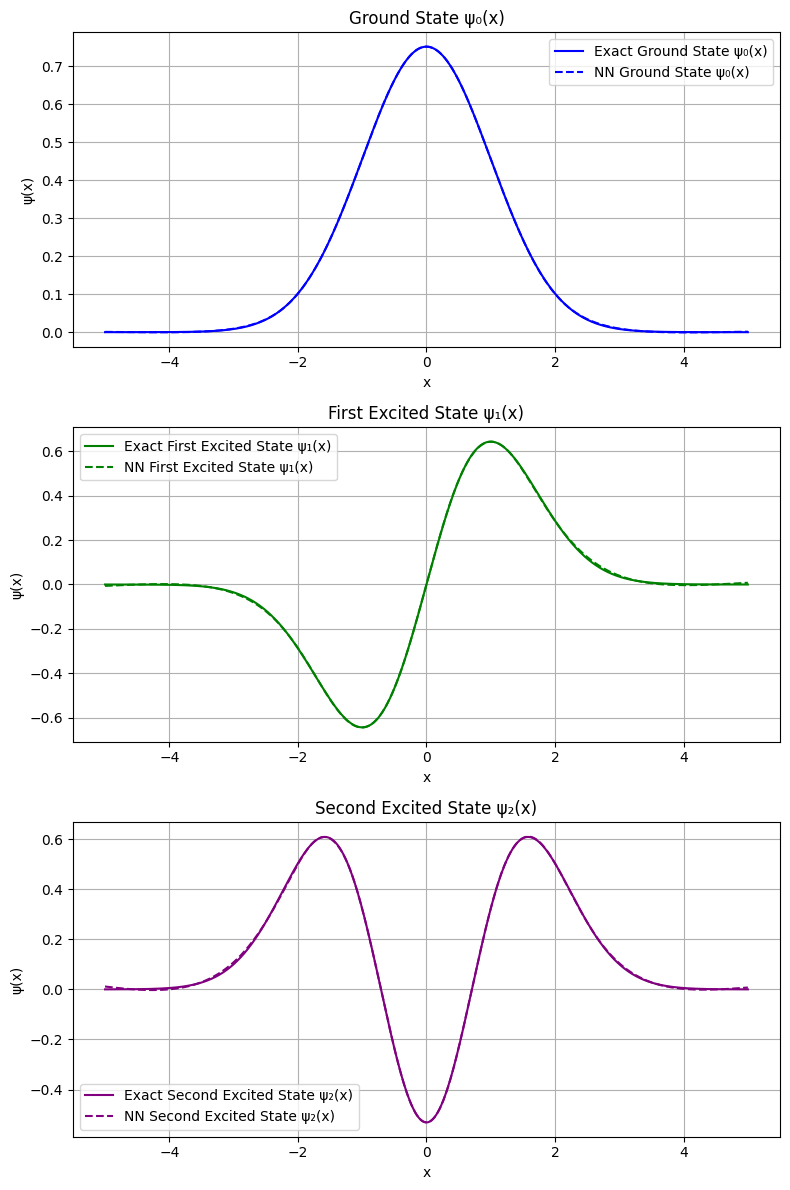

In [41]:
# Create a figure with 3 rows and 1 column for subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Plot the Ground State (ψ₀) in the first row
axes[0].plot(x_np, psi_exact_0, label='Exact Ground State ψ₀(x)', color='blue')
axes[0].plot(x_np, psi_0_aligned, label='NN Ground State ψ₀(x)', color='blue', linestyle='dashed')
axes[0].set_title('Ground State ψ₀(x)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('ψ(x)')
axes[0].legend()
axes[0].grid(True)

# Plot the First Excited State (ψ₁) in the second row
axes[1].plot(x_np, psi_exact_1, label='Exact First Excited State ψ₁(x)', color='green')
axes[1].plot(x_np, psi_1_aligned, label='NN First Excited State ψ₁(x)', color='green', linestyle='dashed')
axes[1].set_title('First Excited State ψ₁(x)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('ψ(x)')
axes[1].legend()
axes[1].grid(True)

# Plot the Second Excited State (ψ₂) in the third row
axes[2].plot(x_np, psi_exact_2, label='Exact Second Excited State ψ₂(x)', color='purple')
axes[2].plot(x_np, psi_2_aligned, label='NN Second Excited State ψ₂(x)', color='purple', linestyle='dashed')
axes[2].set_title('Second Excited State ψ₂(x)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('ψ(x)')
axes[2].legend()
axes[2].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('wavefunctions_aligned.png')
plt.show()

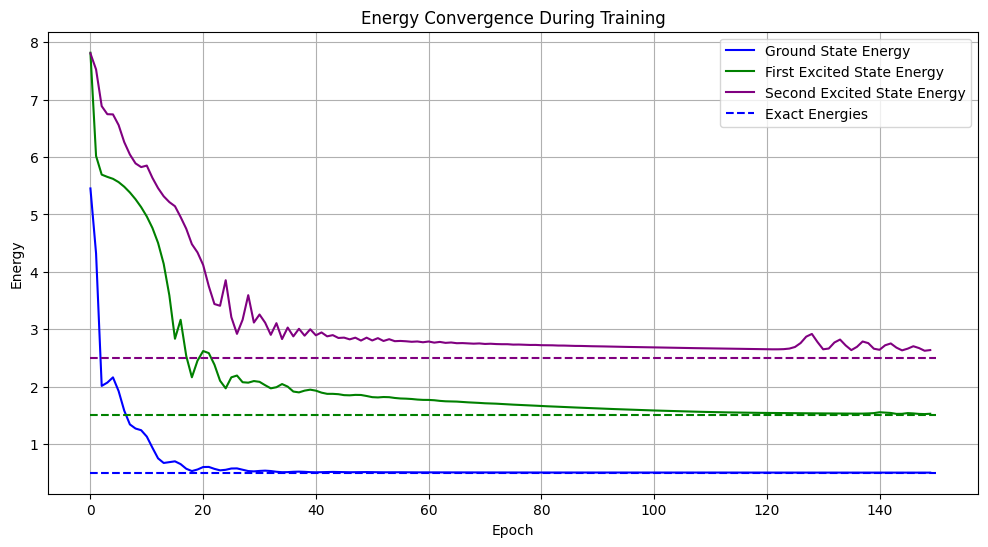

In [40]:
# Plot Energy Convergence
energy_histories=[energy_history_0,energy_history_1,energy_history_2]

x_range_min=0
x_range_max=150

plt.figure(figsize=(12, 6))

plt.plot(energy_histories[0][x_range_min:x_range_max], label='Ground State Energy', color='blue')
plt.plot(energy_histories[1][x_range_min:x_range_max], label='First Excited State Energy', color='green')
plt.plot(energy_histories[2][x_range_min:x_range_max], label='Second Excited State Energy', color='purple')

plt.hlines([0.5, 1.5, 2.5], xmin=x_range_min, xmax=x_range_max, colors=['blue', 'green', 'purple'], linestyles='dashed', label='Exact Energies')

plt.title('Energy Convergence During Training')
plt.xlabel('Epoch')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)

plt.savefig('energy_convergence.png')
plt.show()

In [ ]:
# Animation of Wavefunction Training for Second Excited State
import matplotlib.animation as animation

def animate_wavefunction_training(wf_history, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('x')
    ax.set_ylabel('ψ(x)')
    ax.set_title(title)
    line, = ax.plot([], [], color='blue')
    exact_line, = ax.plot(x_np, psi_exact_2, color='red', linestyle='dashed', label='Exact ψ₂(x)')
    ax.legend()

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        y = wf_history[frame].flatten()
        y=-1*y
        # Normalize for visualization purposes

        line.set_data(x_np, y)
        ax.set_title(f"{title} - Frame ~ {frame}")
        return line,

    ani = animation.FuncAnimation(fig, update, frames=100, init_func=init,
                                  blit=True, interval=100, repeat=True)
    plt.close()
    return ani


ani_second_excited = animate_wavefunction_training(wf_history_2[:100], "Second Excited State ψ₂(x) Evolution")

# Display the animations
from IPython.display import HTML

print("Second Excited State Animation:")
display(HTML(ani_second_excited.to_jshtml()))

# Print the energies
print("\nComputed Energies:")
print(f"Ground State Energy: {energy_0:.4f} (Exact: 0.5)")
print(f"First Excited State Energy: {energy_1:.4f} (Exact: 1.5)")
print(f"Second Excited State Energy: {energy_2:.4f} (Exact: 2.5)")

Second Excited State Animation:



Computed Energies:
Ground State Energy: 0.5000 (Exact: 0.5)
First Excited State Energy: 1.5009 (Exact: 1.5)
Second Excited State Energy: 2.5008 (Exact: 2.5)


In [45]:
# Save the animation
ani_second_excited.save('wavefunction_evolution.gif', writer='imagemagick')